<a href="https://colab.research.google.com/github/Translationalimaginglab/SAR24/blob/main/SAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SAR YOLOV7 workshop.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preprocessing**

This script sets up a project environment in Google Colab by first navigating to the Google Drive directory and creating a new folder.
It then clones kits19 public-database GitHub repository, installs dependencies from it's requirements file,
and runs a Python script to download and prepare imaging data for analysis.

In [ ]:
'''
This script sets up a project environment in Google Colab by first navigating to the Google Drive directory and creating a new folder.
It then clones kits19 public-database GitHub repository, installs dependencies from it's requirements file,
and runs a Python script to download and prepare imaging data for analysis.
'''
%cd /content/drive/MyDrive/

import os

if not os.path.isdir("SAR"):
  os.makedirs ("SAR")
%cd /content/drive/MyDrive/SAR

!git clone https://github.com/neheller/kits19
%cd /content/drive/MyDrive/SAR/kits19
!pip3 install -r requirements.txt
!python3 -m starter_code.get_imaging

In [ ]:
import os

rootdir = "data"
paths = []  # List to store all the directory paths

# Walk through the directory
for root, dirs, files in os.walk(rootdir):
    for dir in dirs:
        # Generate the full filepath
        filepath = os.path.join (dir)
        # Add the filepath to the list
        paths.append(filepath)

# Sort the list of filepaths
paths.sort()

# Write the sorted list of filepaths to the file
with open('kits19.txt', 'w') as f:
    for path in paths:
        f.write(path + "\n")


## **Windowing scans**

In [ ]:
'''

This script adjusts to the kits19 directory on Google Drive and imports necessary libraries for medical image processing.
It defines a function to apply a specific window level and width to medical imaging data, enhancing visualization by adjusting
pixel intensity scales. The script iterates over imaging files in the kits19 folder, applies the windowing function, and saves
the processed images back to the directory, printing the path of the saved files for tracking.

'''
!pip install SimpleITK
%cd /content/drive/MyDrive/SAR/kits19/
import SimpleITK as sitk
import os
import numpy as np

def apply_window(image_array, window_level, window_width):
    min_value = window_level - (window_width / 2)
    max_value = window_level + (window_width / 2)

    windowed_image = np.clip(image_array, min_value, max_value)
    windowed_image = (windowed_image - min_value) / (max_value - min_value)
    windowed_image = np.clip(255 * windowed_image, 0, 255).astype(np.uint8)

    return windowed_image

window_level = 40
window_width = 400

input_dir = 'data'  # Update this path as needed

# Iterate over files in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('imaging.nii.gz')):
            input_file = os.path.join(root, file)
            print(f"Processing file: {input_file}")
            image = sitk.ReadImage(input_file)
            image_array = sitk.GetArrayFromImage(image)

            windowed_image = apply_window(image_array, window_level, window_width)

            # Convert back to SimpleITK image
            windowed_image_sitk = sitk.GetImageFromArray(windowed_image)
            windowed_image_sitk.CopyInformation(image)

            output_subdir = os.path.join(root, f"{file}")
            sitk.WriteImage(windowed_image_sitk, output_subdir)
            print(f"Processed and saved: {output_subdir}")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.6 MB/s eta 0:00:00
/content/drive/MyDrive/SAR/kits19
Processing file: data/case_00000/imaging.nii.gz
Processed and saved: data/case_00000/imaging.nii.gz
Processing file: data/case_00001/imaging.nii.gz
Processed and saved: data/case_00001/imaging.nii.gz
Processing file: data/case_00002/imaging.nii.gz
Processed and saved: data/case_00002/imaging.nii.gz
Processing file: data/case_00003/imaging.nii.gz
Processed and saved: data/case_00003/imaging.nii.gz
Processing file: data/case_00004/imaging.nii.gz
Processed and saved: data/case_00004/imaging.nii.gz
Processing file: data/case_00005/imaging.nii.gz


KeyboardInterrupt: 

## **Converting 3D NIFTI files to 2D**

In [ ]:
'''
This script, operating within the kits19 directory on Google Drive, uses SimpleITK for reading and processing 3D medical images from
specified cases to convert them into 2D slices. It saves these slices into new directories for each case, structured for further use
in detection models, iterating through all cases listed in a text file.
'''

%cd /content/drive/MyDrive/SAR/kits19/
!pip install SimpleITK
import os
import SimpleITK as sitk

def convert_to_2D(case, volumePathName, img_save_root):

    image = os.path.join("data", case, volumePathName)
    volume = sitk.ReadImage(image, sitk.sitkInt16)
    npVolume = sitk.GetArrayViewFromImage(volume)

    img_save_path = os.path.join(img_save_root, case)
    print (img_save_path)
    if not os.path.exists(img_save_path):
        os.makedirs(img_save_path)


    for z in range(npVolume.shape[2]):
        npSlice = npVolume[..., z].T  # Transpose to switch the axes if necessary
        theSlice = sitk.GetImageFromArray(npSlice, isVector=(channels > 1))
        theSlice.SetSpacing([volume.GetSpacing()[2], volume.GetSpacing()[1]])

        fname = volumePathName.replace('.nii.gz', f'{z+1}.nii.gz')
        img_f_path = os.path.join(img_save_path, fname)
        sitk.WriteImage(theSlice, img_f_path)


with open('kits19.txt', mode="rt", newline="") as f:
    cases = [ case.strip() for case in f if len(case.strip()) > 0 ]

for case in cases:
    convert_to_2D(case, "segmentation.nii.gz", "YOLODetection/Masks")
    convert_to_2D(case, "imaging.nii.gz", "YOLODetection/Images")


/content/drive/MyDrive/SAR/kits19


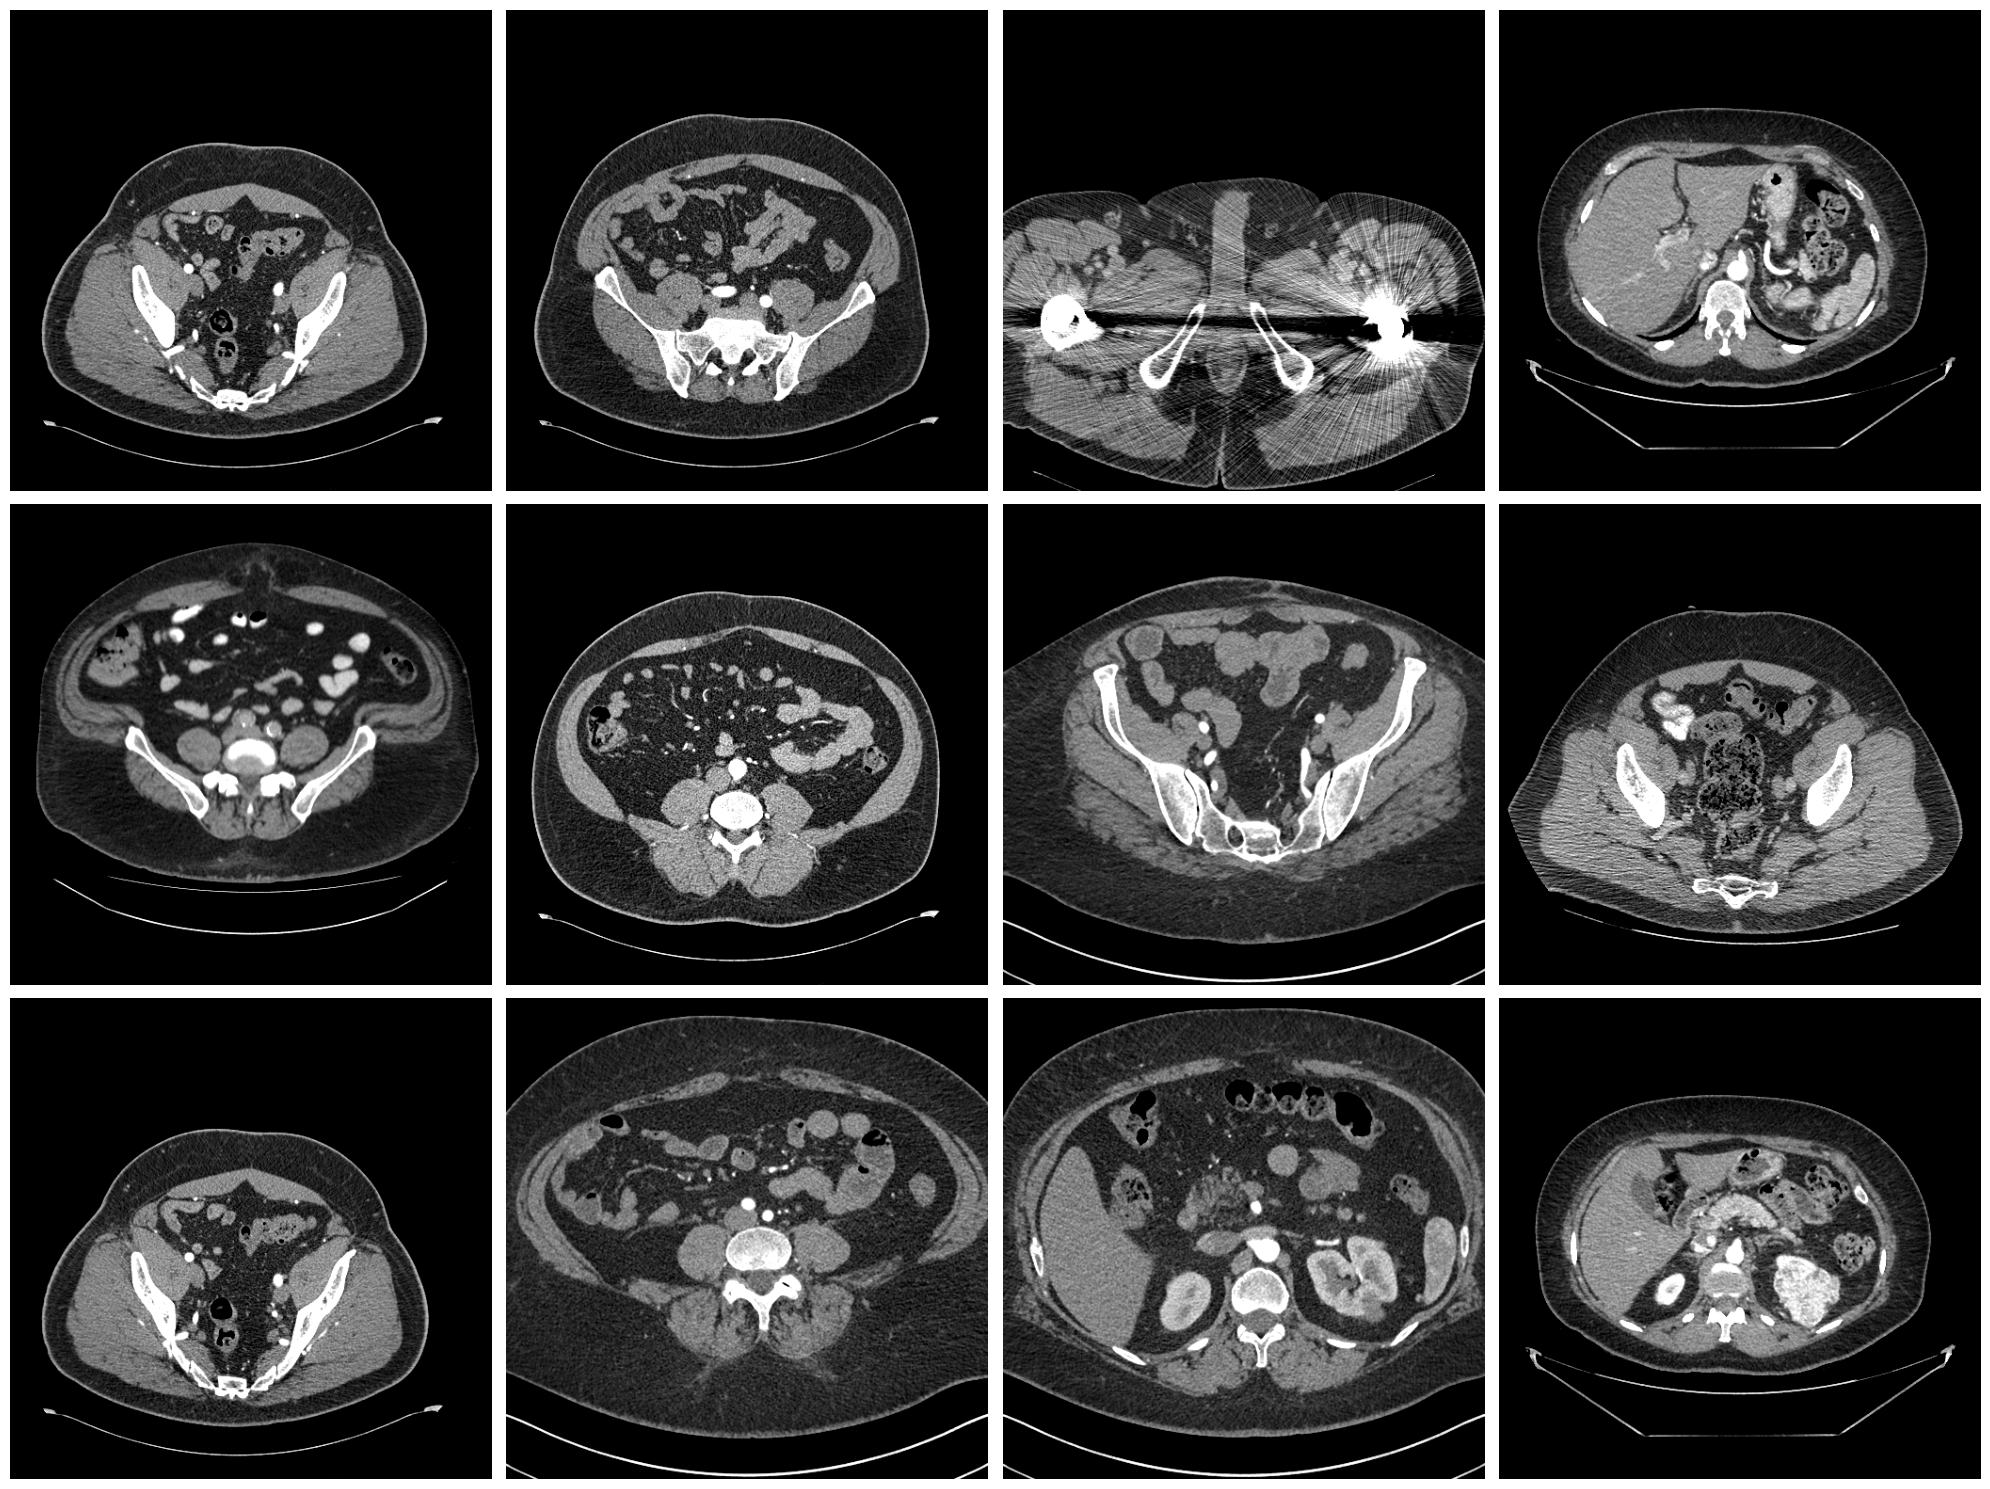

In [ ]:
'''
This part reads the list of patient the kits19 text file, randomly selects a subset of their imaging files, and displays these images with
improved contrast using matplotlib.
'''
!pip install SimpleITK
%cd /content/drive/MyDrive/SAR/kits19

import os
import random
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def read_patient_list(filename="kits19.txt"):
    with open(filename, "r") as file:
        patients = [line.strip() for line in file.readlines() if line.strip()]
    return patients

def find_images(images_dir, patient_list, num_cases=12):
    selected_patients = random.sample(patient_list, min(len(patient_list), num_cases))
    image_paths = []

    for patient in selected_patients:
        patient_image_dir = os.path.join(images_dir, patient)
        image_files = [f for f in os.listdir(patient_image_dir) if f.startswith('imaging') and f.endswith('.nii.gz')]
        for image_file in image_files:
            image_path = os.path.join(patient_image_dir, image_file)
            image_paths.append(image_path)

    return image_paths


def display_images(image_paths, num_images=12):
    if not image_paths:
        print("No images to display.")
        return

    num_images = min(len(image_paths), num_images)
    selected_paths = random.sample(image_paths, num_images)
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.ravel()

    for i, image_path in enumerate(selected_paths):
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)

        # Use percentile scaling to improve contrast, avoiding division by zero
        v_min, v_max = np.percentile(image_array, (1, 99))  # Adjust these percentiles if needed
        if v_max - v_min > 0:  # Avoid division by zero
            image_array = np.clip(image_array, v_min, v_max)
            image_norm = (image_array - v_min) / (v_max - v_min)
        else:
            # If there is no variation, we can set the image to mid-gray or skip normalization
            image_norm = np.full_like(image_array, 0.5)

        axs[i].imshow(image_norm, cmap='gray')
        axs[i].axis('off')

    # Remove any unused subplots if we have fewer than 12 images
    for j in range(i + 1, 12):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


# Define directories and file path
images_dir = 'YOLODetection/Images'
kits19_file_path = 'kits19.txt'

# Read patient list and find images
patient_list = read_patient_list(kits19_file_path)
image_paths = find_images(images_dir, patient_list)

# Display images
display_images(image_paths, num_images=12)

In [ ]:
'''
# This part delete the txt files in the YOLODetection folder if neccessary

import os

# Set the directory you want to start from
root_dir = "/content/drive/My Drive/SAR/kits19/YOLODetection"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith('.txt'):
            file_path = os.path.join(dirpath, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")
'''

In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import sys
import re
import math
import csv
import functools
import operator

with open('kits19.txt', mode="rt", newline="") as f:
    cases = [case.strip() for case in f if case.strip()]

for case in cases:
    ImagePath = os.path.join('YOLODetection','Masks', case)
    No_of_files = len(os.listdir(ImagePath))
    for i in range(No_of_files):
        MaskFile = os.path.join(ImagePath, f"segmentation{i+1}.nii.gz")  # Directly use the string path
        Mask = sitk.ReadImage(MaskFile)

        voxelArea = functools.reduce(operator.mul, Mask.GetSpacing()[:2])
        npMask = sitk.GetArrayViewFromImage(Mask)
        npMask = (npMask == 2).astype(np.int16)  # Focus on RCC tumors

        Mask = sitk.GetImageFromArray(npMask)  # Create a binary mask
        ccFilter = sitk.ConnectedComponentImageFilter()
        ccFilter.SetFullyConnected(True)

        ccMask = ccFilter.Execute(Mask)
        objCount = ccFilter.GetObjectCount()
        npCCMask = sitk.GetArrayViewFromImage(ccMask)

        for label in range(1, objCount + 1):
            npMaskTumor = (npCCMask == label)
            if npMaskTumor.sum() < 100:  # Filter out small objects
                continue


            Argwhere = np.argwhere(npMaskTumor)
            lower, upper = Argwhere.min(axis=0), Argwhere.max(axis=0)
            center = 0.5 * (lower + upper)
            sizes = upper - lower
            imageHeight, imageWidth = npMask.shape[0], npMask.shape[1]
            relCenterX, relCenterY = center[0] / imageWidth, center[1] / imageHeight
            relSizeX, relSizeY = sizes[0] / imageWidth, sizes[1] / imageHeight

            lines = f'0 {relCenterX} {relCenterY} {relSizeX} {relSizeY}\n'
            save_path = os.path.join('YOLODetection','Images', case, f'imaging{i}.txt')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
            print (save_path)
            with open(save_path, 'a') as file:
                file.write(lines)

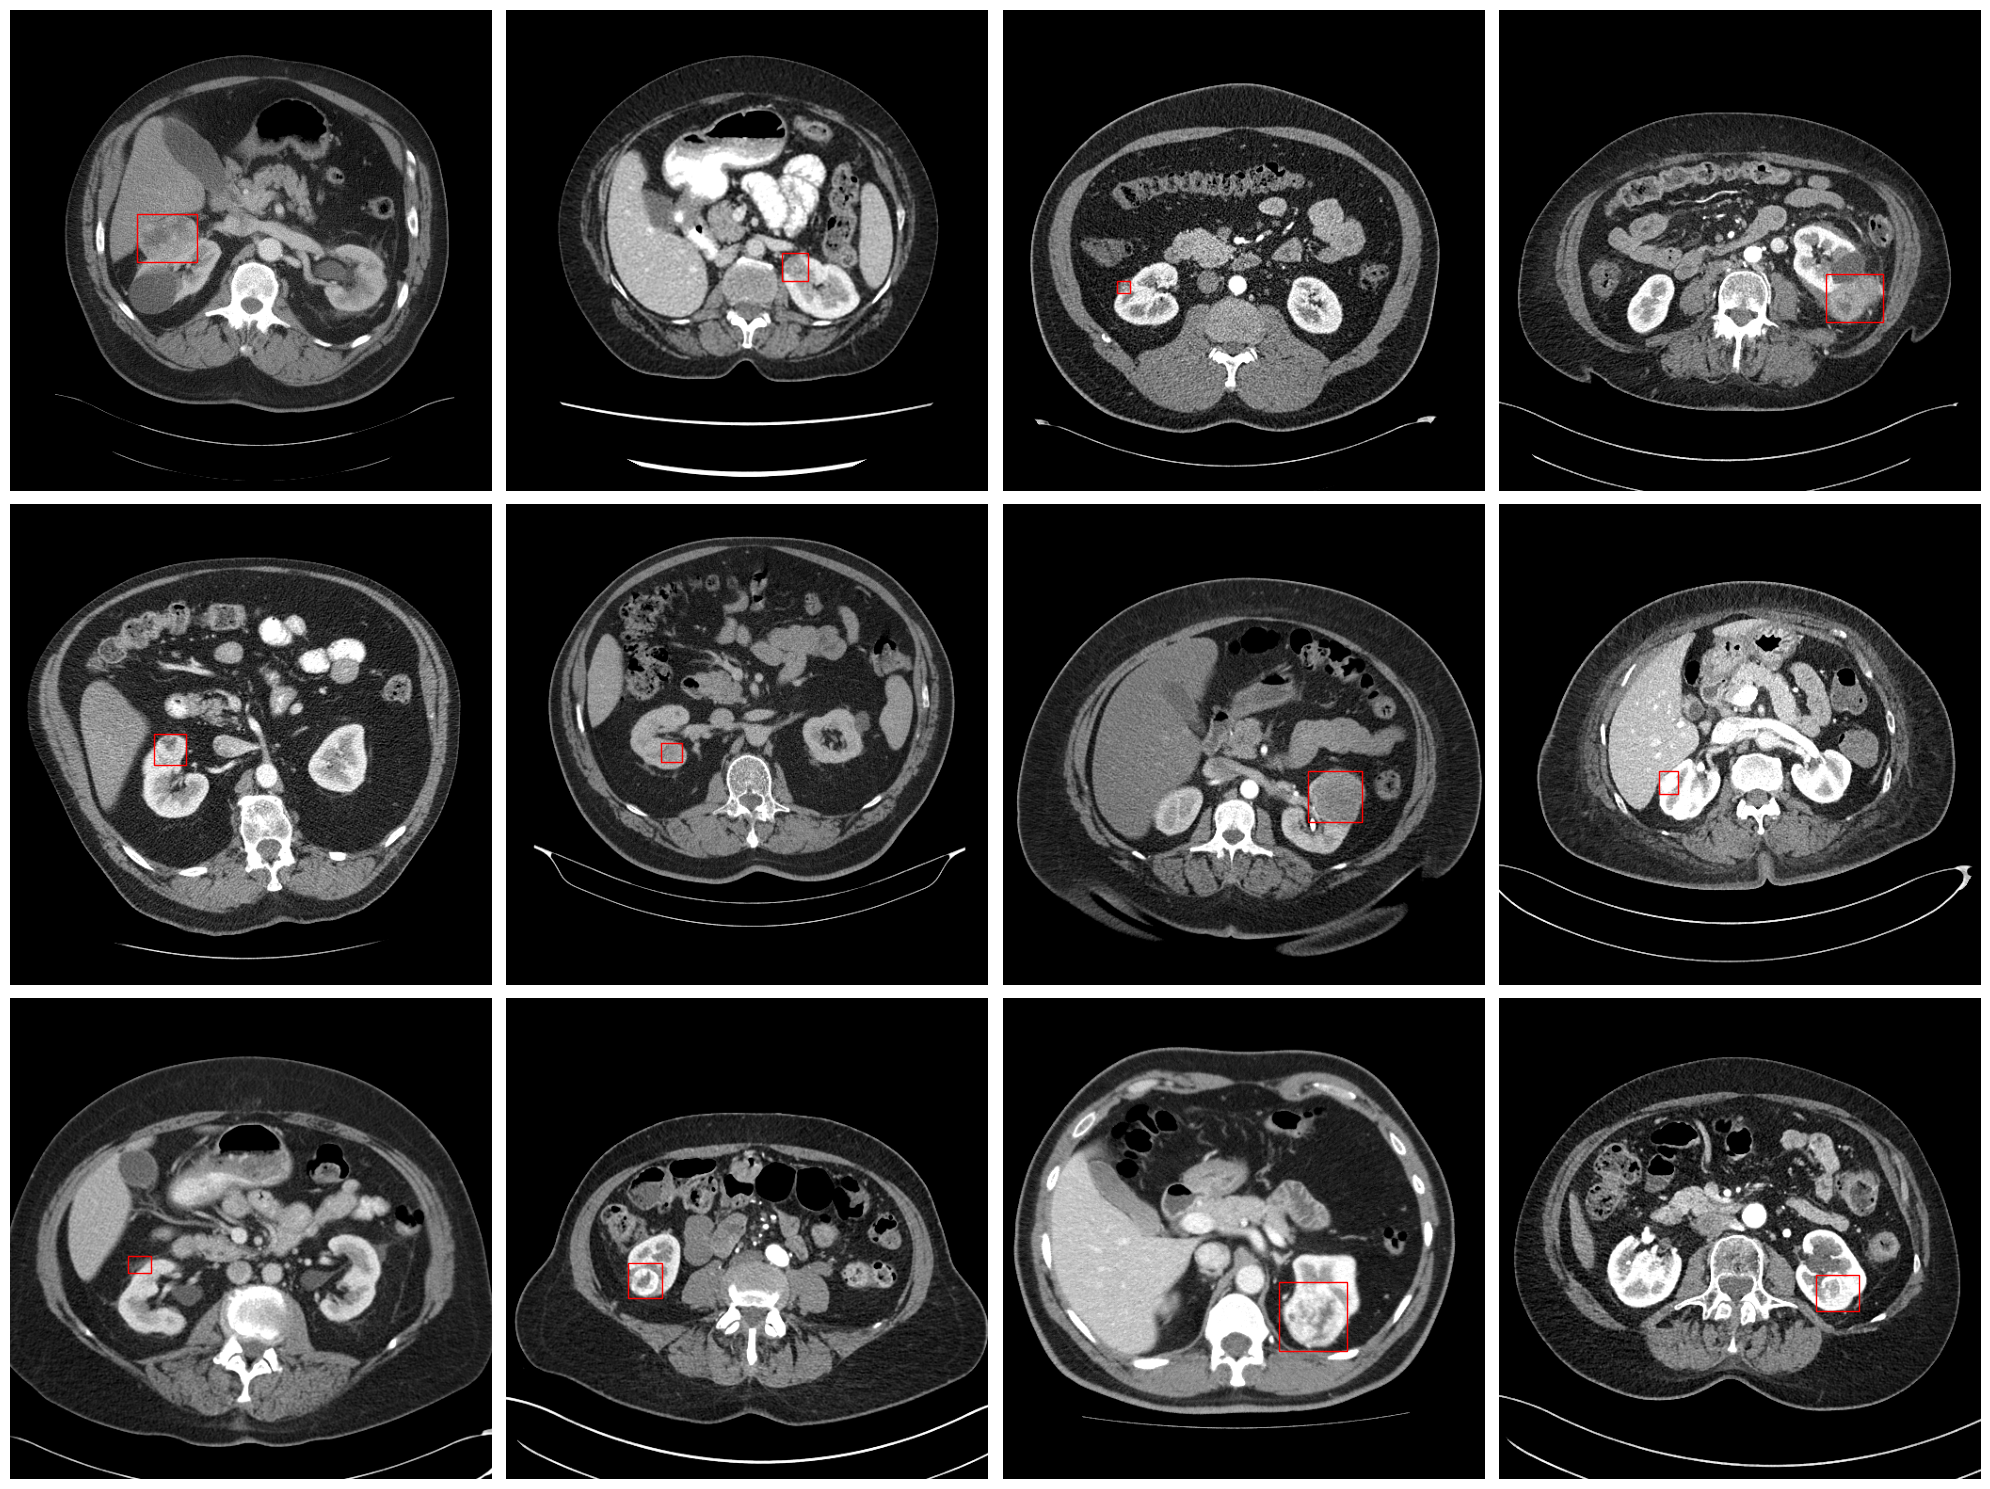

In [ ]:
import os
import random
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def read_patient_list(filename="kits19.txt"):
    with open(filename, "r") as file:
        patients = [line.strip() for line in file.readlines() if line.strip()]
    return patients

def select_random_image_with_txt(images_dir, patient):
    patient_image_dir = os.path.join(images_dir, patient)
    image_files = [f for f in os.listdir(patient_image_dir) if f.endswith('.nii.gz')]
    paired_files = [(f, f.replace('.nii.gz', '.txt')) for f in image_files if os.path.exists(os.path.join(patient_image_dir, f.replace('.nii.gz', '.txt')))]

    if not paired_files:
        return None, None
    selected_image, selected_txt = random.choice(paired_files)
    return os.path.join(patient_image_dir, selected_image), os.path.join(patient_image_dir, selected_txt)

def load_coordinates(txt_path):
    coords = []
    with open(txt_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:  # Verify correct number of parts
                coords.append([float(part) for part in parts[1:]])  # Skip the label part
    return coords

def draw_bounding_box(image_path, coords_list, ax):
    image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(image)
    img_shape = image_array.shape

    for coords in coords_list:
        # Adjust coordinates to pixel values and calculate top-left corner
        x = int((coords[0] - coords[2] / 2) * img_shape[1])
        y = int((coords[1] - coords[3] / 2) * img_shape[0])
        width = int(coords[2] * img_shape[1])
        height = int(coords[3] * img_shape[0])

        # Draw bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(image_array, cmap='gray')
    ax.axis('off')

def main():
    images_dir = 'YOLODetection/Images'  # Update this path
    kits_file_path = 'kits19.txt'  # Assuming it's in the current directory
    patients = read_patient_list(kits_file_path)
    selected_patients = random.sample(patients, min(len(patients), 12))

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs = axs.ravel()

    for i, patient in enumerate(selected_patients):
        image_path, txt_path = select_random_image_with_txt(images_dir, patient)
        if image_path and txt_path:
            coords_list = load_coordinates(txt_path)
            draw_bounding_box(image_path, coords_list, axs[i])

    plt.tight_layout()
    plt.show()

main()

In [ ]:
import os

# Read the cases from kits19.txt
with open("kits19.txt", mode="rt") as f:
    cases = [case.strip() for case in f if len(case.strip()) > 0]
rootdir = 'YOLODetection'

# Initialize an empty set to track unique file paths
unique_file_paths = set()

# Walk through the directory structure
for subdir, dirs, files in os.walk(rootdir):
    abs_subdir = os.path.abspath(subdir)
    for file in files:
        if file.endswith(".txt"):
            filepath = os.path.join(abs_subdir, file)
            nii_gz_filepath = filepath.replace(".txt", ".nii.gz")
            unique_file_paths.add(nii_gz_filepath)

# Check if WholeData.txt exists, if not, create it or clear its content
if not os.path.exists("WholeData.txt"):
    open("WholeData.txt", 'w').close()
# Append unique file paths with the new extension to WholeData.txt
with open("WholeData.txt", "a") as f:
    for filepath in unique_file_paths:
        f.write(filepath + "\n")

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the file content
file_path = 'WholeData.txt'
data = pd.read_csv(file_path, header=None, names=['file_path'])

# Split the data into train and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Save the train and test sets to new files
train_set_file_path = 'train_set.txt'
test_set_file_path = 'test_set.txt'
train_set.to_csv(train_set_file_path, header=False, index=False)
test_set.to_csv(test_set_file_path, header=False, index=False)

train_set_file_path, test_set_file_path

In [ ]:
%cd /content/drive/MyDrive/SAR
!git clone https://github.com/Translationalimaginglab/YOLOV7-RCC
%cd /content/drive/MyDrive/SAR/YOLOV7-RCC/
!pip3 install -r requirements.txt

In [ ]:
pip install "numpy<1.24"

In [ ]:
%cd /content/drive/MyDrive/SAR/YOLOV7-RCC
!pip install SimpleITK
!python train.py --device 0 --batch-size 16 --epochs 25 --img 416 416 --data data/cocoTumorDetect1.yaml --cfg cfg/training/customDetect.yaml --name Detect1 --weights ''

/content/drive/MyDrive/SAR/YOLOV7-RCC
2024-04-15 22:29:59.651087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 22:29:59.651144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 22:29:59.652534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 22:29:59.659873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 22:3